<a href="https://colab.research.google.com/github/genaiconference/Agentic_RAG_Workshop/blob/main/02_chunking_and_indexing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Chunks and Store them in Azure Search Index / Chroma DB

In [ ]:
!git clone https://github.com/genaiconference/Agentic_RAG_Workshop.git

Cloning into 'Agentic_RAG_Workshop'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 294 (delta 101), reused 57 (delta 39), pack-reused 116 (from 1)
Receiving objects: 100% (294/294), 31.60 MiB | 7.72 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Updating files: 100% (50/50), done.


## Setup and Installations
Install necessary libraries for document processing, data handling, and interacting with Azure Document Intelligence and OpenAI.

In [ ]:
!pip install -r /content/Agentic_RAG_Workshop/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 20.2 MB/s et

## Load Environment Variables and Initialize Clients
Load environment variables containing API keys and endpoint information, and initialize the Azure Document Intelligence and OpenAI clients.

In [ ]:
import os

os.chdir("/content/Agentic_RAG_Workshop/")

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()

doc_intelligence_endpoint=os.getenv("doc_intelligence_endpoint")
doc_intelligence_key=os.getenv("doc_intelligence_key")


llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4.1",
    temperature=0,
)

embeddings = OpenAIEmbeddings(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="text-embedding-3-small"
)

## Load DI output for one of the documents
To demonstrate the chunking and Indexing Process, we choose Insurance_Policy.pdf document

In [ ]:
import pickle
import os

DI_OUTPUT_DIR = os.path.join(os.getcwd(), "DI_output")

insurance_policy_results = pickle.load(open(os.path.join(DI_OUTPUT_DIR, "Insurance_Policy_results.pkl"), "rb"))
print(insurance_policy_results.keys())

dict_keys(['md_result', 'result_with_image_descp'])


## MultiVector Retriever

It can often be beneficial to store multiple vectors per document. There are multiple use cases where this is beneficial. LangChain has a base MultiVectorRetriever which makes querying this type of setup easy.

The methods to create multiple vectors per document include:

**Smaller chunks:** split a document into smaller chunks, and embed those (this is ParentDocumentRetriever).

**Summary:** create a summary for each document, embed that along with (or instead of) the document.

**Hypothetical questions:** create hypothetical questions that each document would be appropriate to answer, embed those along with (or instead of) the document.

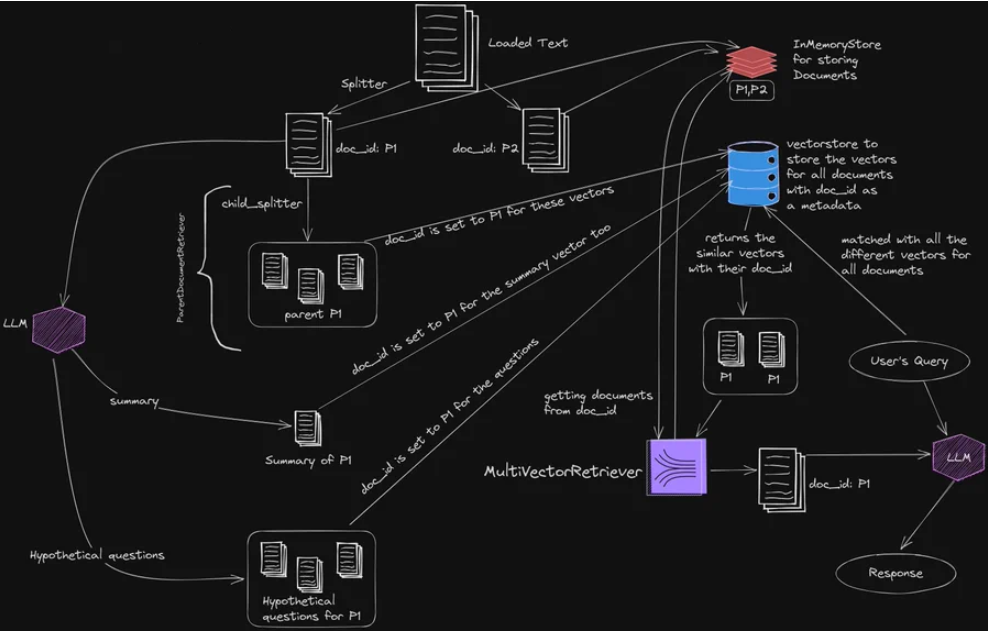

**Illustration of how children, summaries and hypothetical questions are made out of a parent**

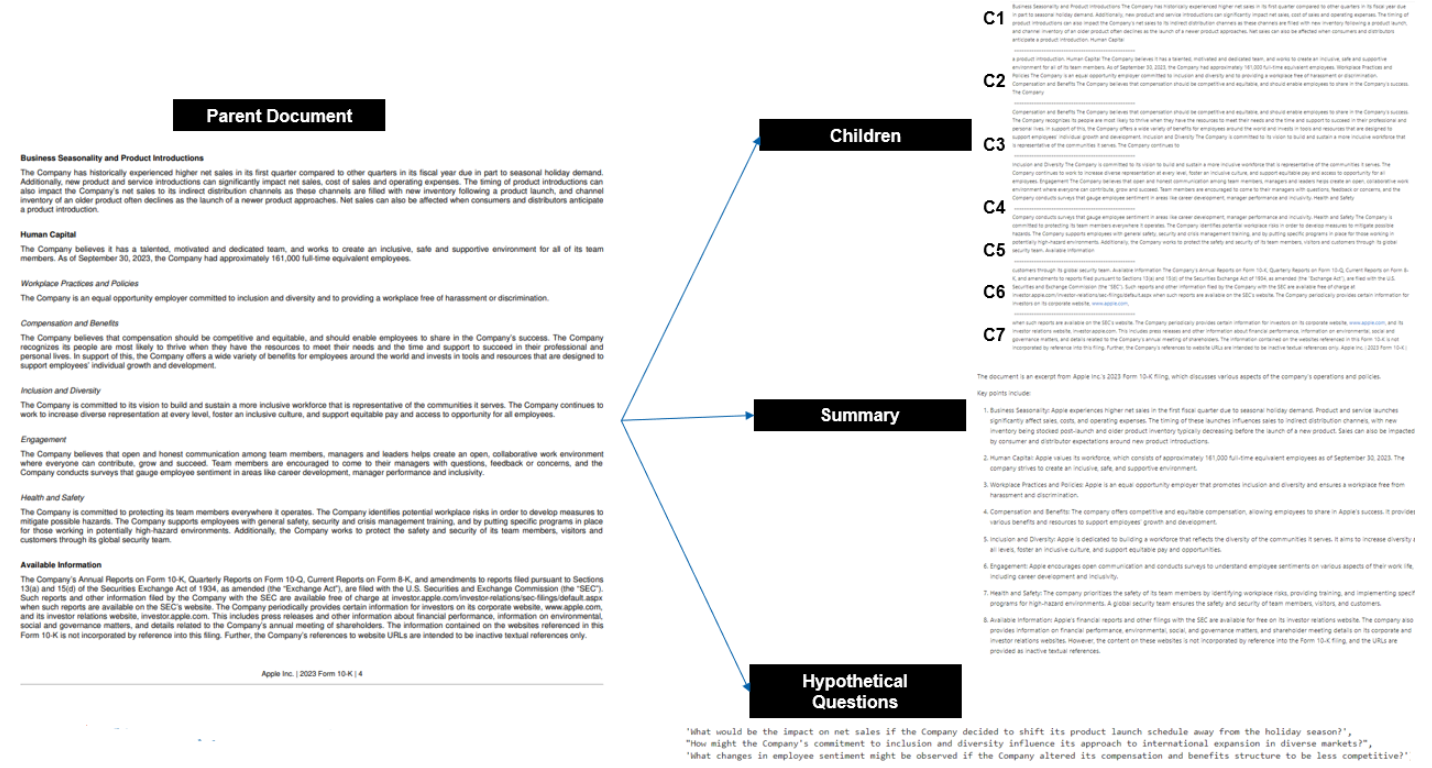




## Chunking

Split the DI markdown output into chunks using Langchain's MarkdownTextSplitter

- This splitter allows us to perform Context-aware splitting
- Preserves header metadata in our chunks.
- It splits a markdown file based on the header or any subheaders and then it adds those headers as content to the metadata fields

### Create Parent Docs

In [ ]:
from langchain_text_splitters import MarkdownHeaderTextSplitter
import uuid

# Initialize the MarkdownHeaderTextSplitter with custom headers to split the parent documents
parent_headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2")
]

# Create splitter with current configuration
splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=parent_headers_to_split_on,
    strip_headers=True
)

markdown_content = insurance_policy_results['result_with_image_descp']

# Split the document
parent_docs = splitter.split_text(markdown_content)

# Create doc ids for parent docs
doc_ids = [str(uuid.uuid4()) for _ in parent_docs]

print("Number of parent documents created :", len(parent_docs))

Number of parent documents created : 45


### Smaller Chunks - Create Child Documents
Often times it can be useful to retrieve larger chunks of information, but embed smaller chunks. This allows for embeddings to capture the semantic meaning as closely as possible, but for as much context as possible to be passed downstream.


In [ ]:
# Initialize the MarkdownHeaderTextSplitter with custom headers to create smaller chunks/child documents
child_headers_to_split_on =[
    ("###", "Header 3"),
    ("####", "Header 4"),
]

id_key = "doc_id"

child_text_splitter = MarkdownHeaderTextSplitter(child_headers_to_split_on)

sub_docs = []
for i, doc in enumerate(parent_docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_text(doc.page_content) # Use split_text and pass the page_content
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
        # Add parent document metadata to the child document
        _doc.metadata.update(doc.metadata)
        _doc.metadata['parent_id'] = _id
    sub_docs.extend(_sub_docs)

for item in sub_docs:
    item.metadata['source_type'] = 'Children'

print("Number of child documents created :", len(sub_docs))

Number of child documents created : 52


### Summary
**Associating summaries with a document for retrieval**

A summary may be able to distill more accurately what a chunk is about, leading to better retrieval. Here we show how to create summaries, and then embed those.

We construct a simple chain that will receive an input Document object and generate a summary using a LLM.

In [ ]:
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(parent_docs, {"max_concurrency": 5})

# Prepare the summaries created in document format
summary_docs = [
    Document(page_content=s, metadata={"source_type" : "summary", id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# let's check how it looks
print(summaries)

['It appears that the document only contains the header: "AON". There is no additional content provided to summarize. If you can provide the full text or more details from the document, I’d be happy to help summarize it!', "The provided document contains only a page footer with company information for Aon India Insurance Brokers Private Limited (formerly Anviti Insurance Brokers Private Limited). It includes the company's CIN (U66000KA2016PTC095559), status as a composite insurance broker, IRDAI license number (624) valid until 15/10/2023, website (aon.com), and registered office address (Unit 102, 1st Floor, The Estate, 121 Dickenson Road, Bengaluru 560042). No additional content is present in the document.", '**Summary:**\n\nThe Group Medical policy provides coverage for employees and their eligible family members for hospitalization expenses due to sickness or accident. Covered expenses include room rent, medicines, and surgery, but only if hospitalization lasts at least 24 hours. T

### Hypothetical Queries

An LLM can also be used to generate a list of hypothetical questions that could be asked of a particular document, which might bear close semantic similarity to relevant queries in a RAG application. These questions can then be embedded and associated with the documents to improve retrieval.

Below, we use the with_structured_output method to structure the LLM output into a list of strings.

In [ ]:
from typing import List
from pydantic import BaseModel, Field


class HypotheticalQuestions(BaseModel):
    """Generate hypothetical questions."""

    questions: List[str] = Field(..., description="List of questions")


chain = (
    {"doc": lambda x: x.page_content}
    # Only asking for 3 hypothetical questions, but this could be adjusted
    | ChatPromptTemplate.from_template(
        "Generate a list of exactly 3 hypothetical questions that the below document could be used to answer:\n\n{doc}"
    )
    | ChatOpenAI(max_retries=0, model="gpt-4o").with_structured_output(
        HypotheticalQuestions
    )
    | (lambda x: x.questions)
)

# Batch chain over documents to generate hypothetical questions
hypothetical_questions = chain.batch(parent_docs, {"max_concurrency": 5})

# Generate Document objects from hypothetical questions
question_docs = []
for i, question_list in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=s, metadata={id_key: doc_ids[i]}) for s in question_list]
    )

# lets check how it looks
print(question_docs)

[Document(metadata={'doc_id': '2ee3274b-487d-4ffe-b3eb-ae5b8fe7280e'}, page_content='What are the key strategies employed by AON in managing risk and insurance for global corporations?'), Document(metadata={'doc_id': '2ee3274b-487d-4ffe-b3eb-ae5b8fe7280e'}, page_content='How does AON utilize data analytics to innovate in the insurance and risk management sectors?'), Document(metadata={'doc_id': '2ee3274b-487d-4ffe-b3eb-ae5b8fe7280e'}, page_content='In what ways does AON ensure compliance with international regulations while serving clients in multiple countries?'), Document(metadata={'doc_id': '719a5383-1851-425d-b19c-93a33e5e6ff6'}, page_content="What would be the process for renewing Aon India Insurance Brokers Private Limited's IRDAI license after its expiration on October 15, 2023?"), Document(metadata={'doc_id': '719a5383-1851-425d-b19c-93a33e5e6ff6'}, page_content='Given its recent rebranding, how has Aon India Insurance Brokers Private Limited adapted its business strategies to 

## Initialize Vectorstore
Vector databases are a new database category that stores vectors or embeddings. They also help in similarity searches. Most popular ones are Pinecone & Weaviate. Chroma & FAISS are easy to work with locally.

Now, we will create embeddings for the child chunks of the PDF and then store them in a vector store. We use OpenAI to create these embeddings.

We will use Chroma as the vector store in our case. Chroma is lightweight and in memory making it easy to start with.

In [ ]:
# Running Locally (with Data Persistence)
from langchain_chroma import Chroma

# You can provide the persist_directory argument to save your data across multiple runs of your program
persist_directory = os.path.join(os.getcwd(), "chroma_insurance_policy")

# The vectorstore to use to index the child chunks (creating an empty vectorstore for now)
vector_store = Chroma(
    collection_name="documents",
    embedding_function=embeddings,
    persist_directory=persist_directory,
)

## Initialize MultiVectorRetriver

In [ ]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore

# The storage layer for the parent documents
store = InMemoryByteStore()


# The retriever (empty to start)
mvr_retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    byte_store=store,
    id_key=id_key,
)

# Doc ID are assigned to each Parent.
mvr_retriever.docstore.mset(list(zip(doc_ids, parent_docs)))

Now let's check how the doc_ids are assigned to each parent document

In [ ]:
mvr_retriever.docstore.store

### Add Child documents to the vectorstore

In [ ]:
mvr_retriever.vectorstore.add_documents(sub_docs)
print("Successfully added children to the vector store")

Successfully added children to the vector store


In [ ]:
# Vectorstore alone retrieves the small chunks
mvr_retriever.vectorstore.similarity_search("Maternity leave")[0]

Document(id='a0c90e8b-1f9a-4f60-b1c3-4f38bb99f4e8', metadata={'parent_id': '19a7660f-1e3f-4cce-94e5-3b101a1eb435', 'Header 2': 'Your Plan Details Maternity Benefits', 'Header 1': 'Employee Benefits Manual 2023-24 Novartis Group', 'source_type': 'Children', 'doc_id': '19a7660f-1e3f-4cce-94e5-3b101a1eb435'}, page_content='· Maternity benefits are admissible only if the expenses are incurred in Hospital / Nursing Home as in-patients in India.\n· Those Insured Persons who already have two or more living children will not be eligible for this benefit.\n· Expenses incurred in connection with voluntary medical termination of pregnancy during the first 12 weeks from the date\nof conception are not covered. Infertility Treatment and sterilization are excluded from the policy.')

In [ ]:
# Retriever returns larger chunks
mvr_retriever.invoke("Maternity leave")[0]

Document(metadata={'Header 1': 'Employee Benefits Manual 2023-24 Novartis Group', 'Header 2': 'Your Plan Details Maternity Benefits'}, page_content='· Maternity benefits are admissible only if the expenses are incurred in Hospital / Nursing Home as in-patients in India.  \n· Those Insured Persons who already have two or more living children will not be eligible for this benefit.  \n· Expenses incurred in connection with voluntary medical termination of pregnancy during the first 12 weeks from the date\nof conception are not covered. Infertility Treatment and sterilization are excluded from the policy.  \n### The maternity benefit under your Group Medical Plan  \n<table>\n<tr>\n<td>Maximum Benefit</td>\n<td>INR 75,000 for Normal &amp; INR 1 Lac (New) for C - Section within Sum Insured Limit</td>\n</tr>\n<tr>\n<td>9-months waiting period</td>\n<td>Waived off</td>\n</tr>\n<tr>\n<td>Pre-Post Natal expenses</td>\n<td>Covered up to INR 5,000 over and above the maternity limit</td>\n</tr>\n<t

### Add the summary documents to the vector store

In [ ]:
mvr_retriever.vectorstore.add_documents(summary_docs)
print("Successfully added summaries to the vector store")

Successfully added summaries to the vector store


When we try similary search on the vector DB we get the children document and the summaries

In [ ]:
mvr_retriever.vectorstore.similarity_search("Maternity leave")

[Document(id='9871b540-9b0d-493e-ad09-5e90f771475e', metadata={'source_type': 'summary', 'doc_id': '19a7660f-1e3f-4cce-94e5-3b101a1eb435'}, page_content='**Summary of Maternity Benefits under the Group Medical Plan:**\n\n- **Eligibility:** Maternity benefits are available only for in-patient hospital/nursing home expenses in India. Employees with more than two living children are not eligible. Expenses for voluntary medical termination of pregnancy within the first 12 weeks, infertility treatment, and sterilization are not covered.\n- **Coverage Details:**\n  - Maximum benefit: INR 75,000 for normal delivery; INR 1,00,000 for C-section (within the sum insured limit).\n  - 9-month waiting period: Waived.\n  - Pre- and post-natal expenses: Covered up to INR 5,000, over and above the maternity limit.\n  - Newborn baby: Covered from day 1, provided HR is informed within 15 days of birth.\n- **Important:** Claims must be submitted within 30 days; do not wait until returning to work. Immedia

### Add the question documents to the vector store

In [ ]:
mvr_retriever.vectorstore.add_documents(question_docs)
print("Successfully added hypothetical questions to the vector store")

Successfully added hypothetical questions to the vector store


When we try similary search on the vector DB we get the children document, summaries and the hypothetical questions

In [ ]:
mvr_retriever.vectorstore.similarity_search("Maternity leave")

[Document(id='24b89b23-8ed3-4740-a057-10758c9a09de', metadata={'doc_id': '19a7660f-1e3f-4cce-94e5-3b101a1eb435'}, page_content='What are the conditions under which maternity benefits are granted, and what exclusions apply?'),
 Document(id='9871b540-9b0d-493e-ad09-5e90f771475e', metadata={'doc_id': '19a7660f-1e3f-4cce-94e5-3b101a1eb435', 'source_type': 'summary'}, page_content='**Summary of Maternity Benefits under the Group Medical Plan:**\n\n- **Eligibility:** Maternity benefits are available only for in-patient hospital/nursing home expenses in India. Employees with more than two living children are not eligible. Expenses for voluntary medical termination of pregnancy within the first 12 weeks, infertility treatment, and sterilization are not covered.\n- **Coverage Details:**\n  - Maximum benefit: INR 75,000 for normal delivery; INR 1,00,000 for C-section (within the sum insured limit).\n  - 9-month waiting period: Waived.\n  - Pre- and post-natal expenses: Covered up to INR 5,000, o

## To Enable Hybrid Search, let's define BM25 retriever

BM25 is a ranking function used in information retrieval systems to estimate the relevance of documents to a given search query.

Key aspects of LangChain's BM25 integration:

**BM25Retriever:**
LangChain offers a dedicated BM25Retriever class within langchain_community.retrievers.bm25. This class enables the use of BM25 for retrieving relevant documents based on a given query.

**Keyword-style Search:**
BM25 operates as a keyword-style search algorithm. It calculates relevance scores based on term frequency (how often query terms appear in a document) and inverse document frequency (how rare those terms are across the entire document collection).

**No Embeddings Required:**
Unlike vector-based retrievers that rely on embeddings, BM25 calculates its sparse vectors internally and does not require pre-computed document embeddings. This can be advantageous in scenarios where embedding generation is computationally expensive or not feasible.

**Enhancing RAG:**
Integrating BM25 into the retrieval stage of a RAG pipeline can enhance the model's ability to fetch relevant documents, potentially leading to more accurate and contextually appropriate generated responses.

**Hybrid Search:**
BM25 can be combined with other retrieval methods, such as vector-based search, to create hybrid search systems. This allows for leveraging the strengths of both keyword-based and semantic search approaches.

In [ ]:
from langchain_community.retrievers import BM25Retriever

# Initialize the BM25Retriever
bm25_retriever = BM25Retriever.from_documents(parent_docs)

In [ ]:
bm25_retriever.invoke("Annual Leaves")

[Document(metadata={'Header 1': 'Employee Benefits Manual 2023-24 Novartis Group', 'Header 2': 'Your Plan Details'}, page_content='### Plan Name : Group Term Life  \n<table>\n<tr>\n<td>Policy Holder</td>\n<td>Novartis Healthcare Pvt Ltd, Novartis India Limited and Sandoz Pvt Ltd.</td>\n</tr>\n<tr>\n<td>Period of the Cover</td>\n<td>12 months</td>\n</tr>\n<tr>\n<td>Policy Effective Date</td>\n<td>1st July 2023</td>\n</tr>\n<tr>\n<td>Expiry Date</td>\n<td>30th June 2024</td>\n</tr>\n<tr>\n<td>Insurer</td>\n<td>HDFC Life Insurance Co. Ltd</td>\n</tr>\n<tr>\n<td>Basis of Sum Assured</td>\n<td>3 times of Annual Base Salary (Minimum Sum assured of INR 30 lacs) upto FCL limit of INR 4 Crores - Maximum Age 59 years</td>\n</tr>\n<tr>\n<td>Terminal Illness Rider</td>\n<td>100% of Base Life Cover subject to maximum of INR 2 Cr.</td>\n</tr>\n<tr>\n<td>Members covered under the plan</td>\n<td>Employees of Novartis Healthcare Pvt Ltd, Novartis India Limited and Sandoz Pvt Ltd.</td>\n</tr>\n<tr>\n<td

## Combine results from both the retrievers (MultiVector & BM25)

The **EnsembleRetriever** supports ensembling of results from multiple retrievers. It is initialized with a list of BaseRetriever objects. EnsembleRetrievers rerank the results of the constituent retrievers based on the Reciprocal Rank Fusion algorithm.

By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorithm.

In [ ]:
from langchain.retrievers import EnsembleRetriever

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, mvr_retriever], weights=[0.5, 0.5]
)

In [ ]:
ensemble_retriever.invoke("maternity Leaves")

[Document(metadata={'Header 1': 'Employee Benefits Manual 2023-24 Novartis Group', 'Header 2': 'Your Plan Details Maternity Benefits'}, page_content='· Maternity benefits are admissible only if the expenses are incurred in Hospital / Nursing Home as in-patients in India.  \n· Those Insured Persons who already have two or more living children will not be eligible for this benefit.  \n· Expenses incurred in connection with voluntary medical termination of pregnancy during the first 12 weeks from the date\nof conception are not covered. Infertility Treatment and sterilization are excluded from the policy.  \n### The maternity benefit under your Group Medical Plan  \n<table>\n<tr>\n<td>Maximum Benefit</td>\n<td>INR 75,000 for Normal &amp; INR 1 Lac (New) for C - Section within Sum Insured Limit</td>\n</tr>\n<tr>\n<td>9-months waiting period</td>\n<td>Waived off</td>\n</tr>\n<tr>\n<td>Pre-Post Natal expenses</td>\n<td>Covered up to INR 5,000 over and above the maternity limit</td>\n</tr>\n<